<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Importing-librarys" data-toc-modified-id="Importing-librarys-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Importing librarys</a></span></li><li><span><a href="#data-loader" data-toc-modified-id="data-loader-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>data loader</a></span></li><li><span><a href="#image-super-resolution" data-toc-modified-id="image-super-resolution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>image super resolution</a></span></li><li><span><a href="#Model-Building" data-toc-modified-id="Model-Building-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Model Building</a></span></li><li><span><a href="#model-evaluation" data-toc-modified-id="model-evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>model evaluation</a></span></li></ul></div>

# Importing librarys

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from glob import glob

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as K
from tensorflow.keras.utils import *
from tensorflow.keras.regularizers import *

# data loader

In [3]:
folders = os.listdir('c:\\Users\\SHEHA\\Downloads\\GitHubRepository\\Python2022\\ComputerVision\\Dataset\\Assignment1')
for i,j in enumerate(folders):
    print('{j} folder is lebel {i}'.format(i=i, j=j))

n01440764 folder is lebel 0
n01443537 folder is lebel 1
n01484850 folder is lebel 2
n01491361 folder is lebel 3
n01494475 folder is lebel 4
n01496331 folder is lebel 5


In [4]:
datat = np.sort(np.array(glob('./Dataset/Assignment1/*')))    
len(datat)

6

In [5]:
def all_train_dir(datat):
    kw = list()
    kb = list()

    for j in range(len(datat)//1):
        v1 = np.sort(np.array(glob(datat[j]+'/*')))
        random.shuffle(v1)

        for i in range(len(v1)//1):

            kw.append(v1[i])
            kb.append(j)

    return np.array(kw),np.array(kb)

In [6]:
tdr1, tdr2 = all_train_dir(datat)

In [7]:
print(type(tdr1))
print(tdr1.shape)
print(type(tdr2))
print(tdr2.shape)

<class 'numpy.ndarray'>
(180,)
<class 'numpy.ndarray'>
(180,)


In [9]:
# label encoding
tdr2 = to_categorical(tdr2, len(np.unique(tdr2)))
tdr2

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

In [10]:
# image preprocess
img_size = (224, 224)
batch_size = 180   # giving whole dataset

def preprocess_image(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.resize(image, img_size)
    return image, label

In [11]:
# data loader from directory
dataset1 = tf.data.Dataset.from_tensor_slices((tdr1, tdr2)).shuffle(180)

In [12]:
train_image1 = dataset1.map(preprocess_image).batch(batch_size).prefetch(1)

In [13]:
for i, (x,y) in enumerate(train_image1):
    print(i, x.shape, y.shape)

0 (180, 224, 224, 3) (180, 6)


In [14]:
print(x.dtype)
print(type(x))
print(x.shape)

<dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'>
(180, 224, 224, 3)


In [15]:
b = x

b = b/255
print(b.shape)
dm = 64
b = (tf.image.resize(b, [dm, dm]))
print(b.shape)

(180, 224, 224, 3)
(180, 64, 64, 3)


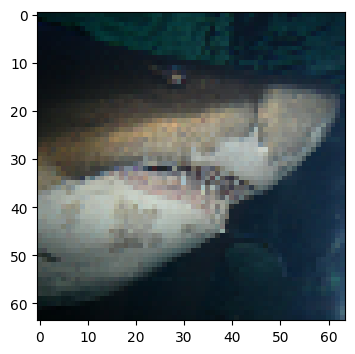

In [16]:
plt.figure(figsize=(4, 4))

n=b[18]
plt.imshow(n)

#  image super resolution


In [20]:
# here fc is a downscale factor

def lsr(im,fc):
    # fc is 0 to 1
    d1=im.shape[1]
    d2=im.shape[2]
    d3=round(d1*fc)
    d4=round(d2*fc)
    w1=  (tf.image.resize(im, [d3, d4]))
    print(w1.shape)
    return  np.float32(tf.image.resize(w1, [d1, d2]))

In [21]:
print("orginal shape", b.shape)
b2d = tf.image.resize(b, [dm//2, dm//2])

ns1 =  lsr(b2d, .75)
ns2 =  lsr(b2d, .85)
ns3 =  lsr(b2d, .65)


all_gt = np.concatenate([b,b,b])
all_ns = np.concatenate([ns1,ns2,ns3])

print(all_gt.shape, all_ns.shape)

orginal shape (180, 64, 64, 3)
(180, 24, 24, 3)
(180, 27, 27, 3)
(180, 21, 21, 3)
(540, 64, 64, 3) (540, 32, 32, 3)


In [22]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split( all_ns, all_gt,  test_size=0.1, random_state=42)

In [23]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(486, 32, 32, 3)
(486, 64, 64, 3)
(54, 32, 32, 3)
(54, 64, 64, 3)


In [24]:
# image augmentation after getting noisy sample
# here all are geometric augmentation, not related to pixel values
def aug_aftr(ary, optn):
    if optn ==1:
        aryaug = tf.image.flip_up_down(ary)
    if optn ==2:
        aryaug=tf.image.transpose(ary)
    else:
        aryaug = tf.image.flip_left_right(ary)
    return aryaug

X_traina = np.concatenate([X_train, aug_aftr(X_train,3), aug_aftr(X_train,1), aug_aftr(X_train,2)])
y_traina = np.concatenate([y_train, aug_aftr(y_train,3), aug_aftr(y_train,1), aug_aftr(y_train,2)])

In [25]:
print(X_traina.shape, y_traina.shape)

(1944, 32, 32, 3) (1944, 64, 64, 3)


In [28]:
def plot_sample(lr, sr):
    plt.figure(figsize=(8, 6))

    images = [lr, sr]
    titles = ['lowres', 'org']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

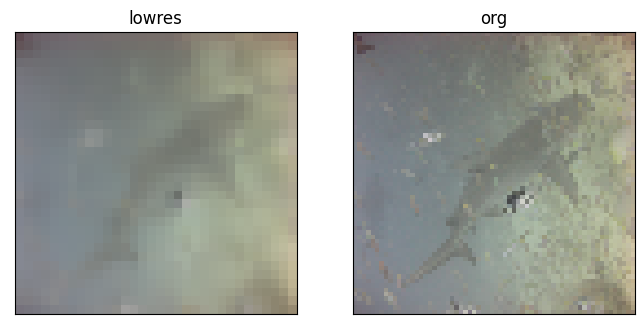

In [29]:
rid = np.random.choice(len(X_traina))
plot_sample(X_traina[rid], y_traina[rid])

# Model Building

In [39]:
def DnCNN():
    input_img = Input(shape=(32,32,3))
    # 1st layer, Conv+relu
    x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(input_img)
    x = Activation('relu')(x)
        # 15 layers, Conv+BN+relu
    for i in range(15):
        x = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same')(x)
        #x = BatchNormalization(axis=-1, epsilon=1e-3)(x)
        x = Activation('relu')(x)
        # last layer, Conv
    x = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding='same')(x)
    x = Subtract()([input_img, x])   # input - blur/low res info
    #x = Add()([input_img, x])   # input + details/high res info
    x = UpSampling2D((2,2))(x)
    model = Model(input_img, x)
    return model


model = DnCNN()
#model.compile(loss='mae', optimizer=opt,    metrics=[  "accuracy"])
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_51 (Conv2D)             (None, 32, 32, 64)   1792        ['input_4[0][0]']                
                                                                                                  
 activation_48 (Activation)     (None, 32, 32, 64)   0           ['conv2d_51[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 32, 32, 64)   36928       ['activation_48[0][0]']          
                                                                                            

In [40]:
bzs = 16
train_dataset = tf.data.Dataset.from_tensor_slices((X_traina, y_traina))
train_dataset = train_dataset.shuffle(buffer_size=1500).batch(bzs)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_dataset = val_dataset.batch(bzs)

In [41]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.4,
                              patience = 6,
                              verbose = 1,
                              min_delta = 0.0001)

# model is saved is on this path
filepath="asset/super_res_model.h5"
checkpoint = ModelCheckpoint(filepath,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')

In [42]:
## accuracy metrics used for denoising and super resolution
# psnr_m best for denoising
# ssim_m best for super resolution

def psnr_m(y_true, y_pred,):
    return  tf.reduce_mean(tf.image.psnr(y_true, y_pred, 1.0))

def ssim_m(y_true, y_pred,):
    return tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

In [43]:
# loss functions
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

def msse(y_true, y_pred):
    return K.mean(tf.keras.losses.mse(y_true, y_pred))


def closs(y_true, y_pred):
    return ( 0.2* SSIMLoss(y_true, y_pred)  + msse(y_true, y_pred))

In [44]:
model.compile(loss=closs, optimizer=optimizer,  metrics=[psnr_m, ssim_m, "accuracy"])

In [45]:
# epochs based on data size
history = model.fit(train_dataset, validation_data=val_dataset,
                    epochs=5, batch_size=8, callbacks = [checkpoint, reduce_lr])

Epoch 1/5
122/122 [==============================] - ETA: 0s - loss: 0.0694 - psnr_m: 24.4828 - ssim_m: 0.6779 - accuracy: 0.9017
Epoch 1: val_loss improved from inf to 0.07624, saving model to asset\super_res_model.h5
122/122 [==============================] - 64s 501ms/step - loss: 0.0694 - psnr_m: 24.4828 - ssim_m: 0.6779 - accuracy: 0.9017 - val_loss: 0.0762 - val_psnr_m: 23.9364 - val_ssim_m: 0.6418 - val_accuracy: 0.9040 - lr: 0.0010
Epoch 2/5
122/122 [==============================] - ETA: 0s - loss: 0.0694 - psnr_m: 24.4740 - ssim_m: 0.6780 - accuracy: 0.9045
Epoch 2: val_loss did not improve from 0.07624
122/122 [==============================] - 59s 483ms/step - loss: 0.0694 - psnr_m: 24.4740 - ssim_m: 0.6780 - accuracy: 0.9045 - val_loss: 0.0763 - val_psnr_m: 23.9326 - val_ssim_m: 0.6417 - val_accuracy: 0.9038 - lr: 0.0010
Epoch 3/5
122/122 [==============================] - ETA: 0s - loss: 0.0694 - psnr_m: 24.4767 - ssim_m: 0.6778 - accuracy: 0.9015
Epoch 3: val_loss did no

# model evaluation

In [46]:
from tensorflow.keras.models import load_model

nmodel = load_model('asset/super_res_model.h5', custom_objects={"psnr_m": psnr_m, "ssim_m": ssim_m, "closs":closs})
nmodel.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_51 (Conv2D)             (None, 32, 32, 64)   1792        ['input_4[0][0]']                
                                                                                                  
 activation_48 (Activation)     (None, 32, 32, 64)   0           ['conv2d_51[0][0]']              
                                                                                                  
 conv2d_52 (Conv2D)             (None, 32, 32, 64)   36928       ['activation_48[0][0]']          
                                                                                            

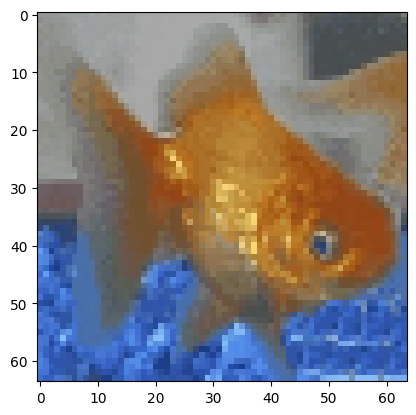

In [66]:
img = b[4]
plt.imshow(img)

In [67]:
img.shape

TensorShape([64, 64, 3])

In [68]:
img = tf.image.resize(img, [32, 32])
img.shape

TensorShape([32, 32, 3])

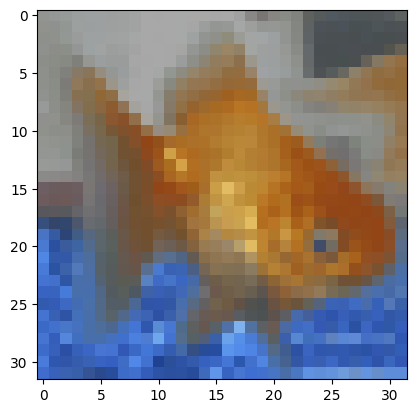

In [69]:
plt.imshow(img)

In [70]:
# from a test image
x_tr = np.expand_dims(img, axis=0)
print(x_tr.shape)

(1, 32, 32, 3)


In [71]:
pred1 = nmodel.predict(x_tr)

1/1 [==============================] - 0s 38ms/step


In [72]:
def plot_sample1(lr, sr):
    plt.figure(figsize=(8, 6))

    images = [lr, sr]
    titles = ['predected', 'org']

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

In [74]:
pred1[0].shape

(64, 64, 3)

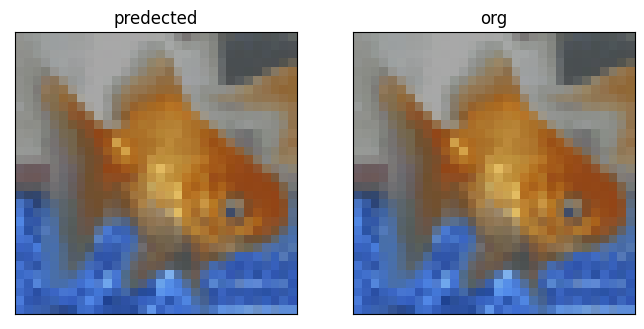

In [73]:
plot_sample1(pred1[0], x_tr[0])